In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import skimage as sk
from scipy import ndimage as ndi

from skimage import exposure
from skimage import io
from skimage import feature
from skimage import filters
from skimage import morphology


# for HEQ
from skimage.filters import rank
from skimage.morphology import disk
from skimage.feature import peak_local_max

%matplotlib inline

In [14]:
img_file = '/Users/kpuhger/Desktop/SampleGFP.tif'
img = sk.io.imread(img_file)

In [15]:
img.shape

(15, 572, 702)

In [23]:
# convenience function for plotting histogram and image together
def img_hist_single(image):

    f, ax = plt.subplots(ncols=2, figsize=(20,10));
    ax[0].hist(image.ravel(), bins=256)
    ax[1].imshow(image, cmap='gray')
    
def img_hist_stack(image, stack):

    f, ax = plt.subplots(ncols=2, figsize=(20,10));
    ax[0].hist(image[stack,:, :].ravel(), bins=256)
    ax[1].imshow(image, cmap='gray')    

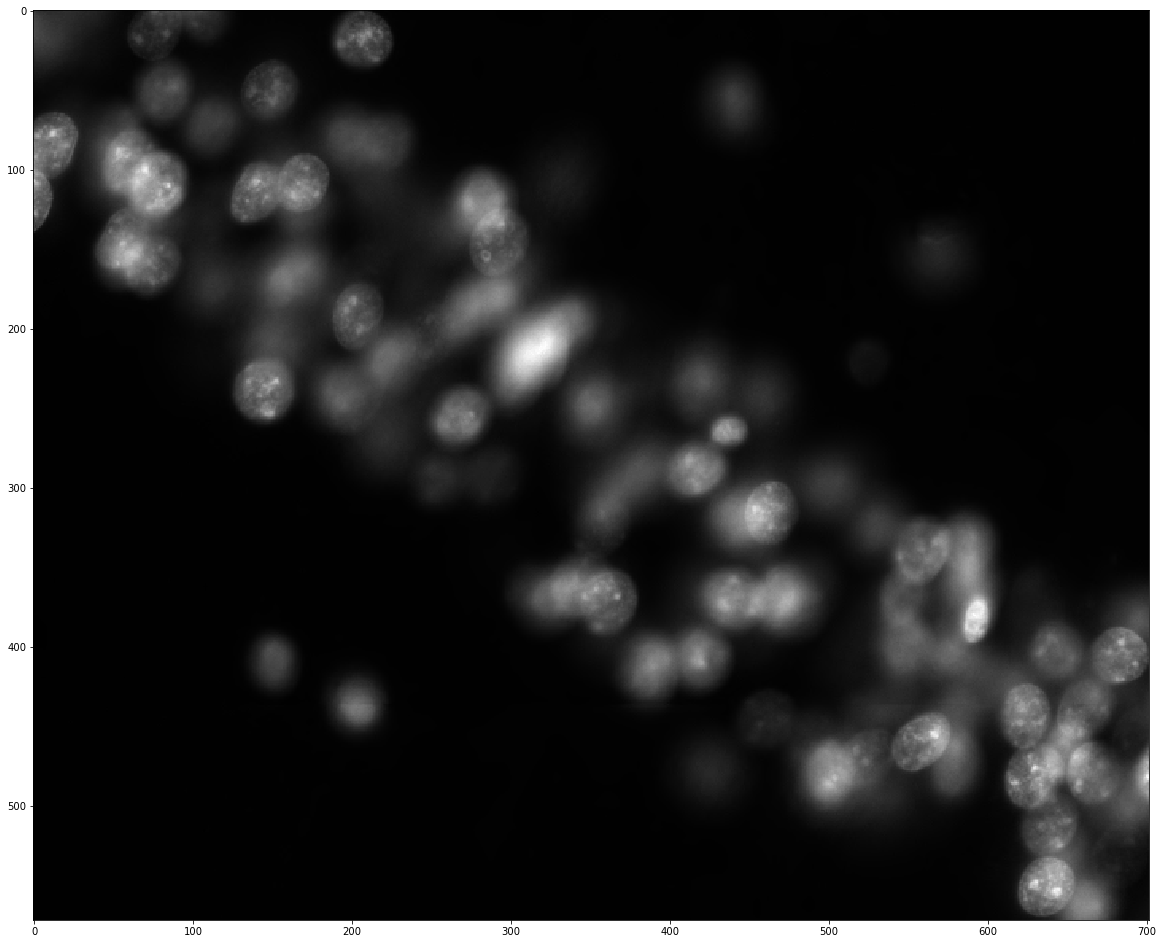

In [17]:
f, ax = plt.subplots(1,1, figsize=(20,20))
ax.imshow(img[9, :, :], cmap='gray');

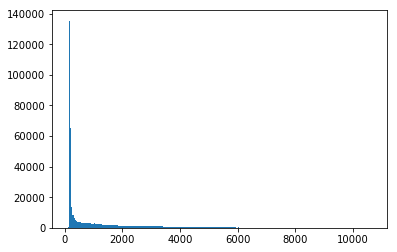

In [18]:
test_img = img[9, :, :]
plt.hist(test_img.ravel(), bins=256);

In [19]:
def gaussian_blur(image, sigma):
    # must convert image to float for this to work in a loop (unknown reason)
    image = (image*1.0)/np.max(image)
    img_gaussian = np.empty_like(image)
    for i in range(len(image)):
        img_gaussian[i,:,:] = filters.gaussian(image[i,:,:], sigma)
    return img_gaussian

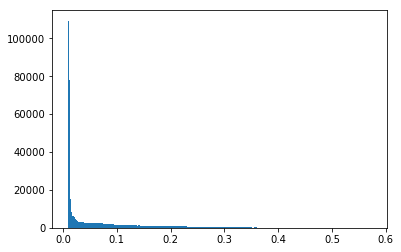

In [20]:
test_blur_stack = gaussian_blur(img, 5)
test_blur_single = test_blur_stack[9, :, :]
plt.hist(test_blur_single.ravel(), bins=256);

# Comparing HEQ methods

## Local equalization

/Users/KPuhger/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


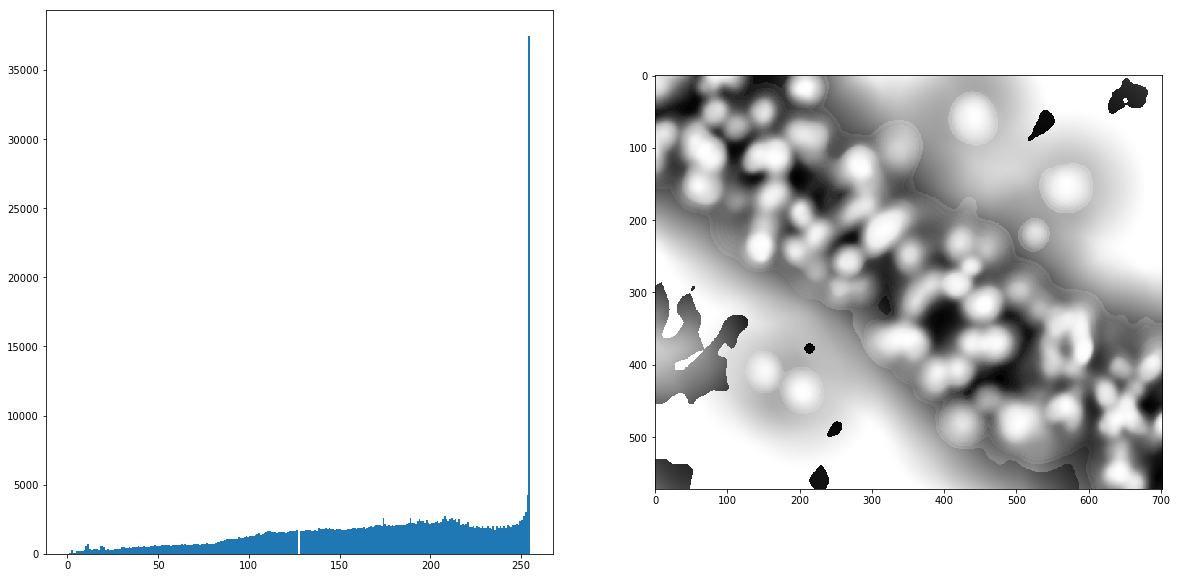

In [24]:
img_rank_eq = rank.equalize(test_blur_single, selem=disk(75))

img_hist_single(img_rank_eq)

img

## Contrast stretch

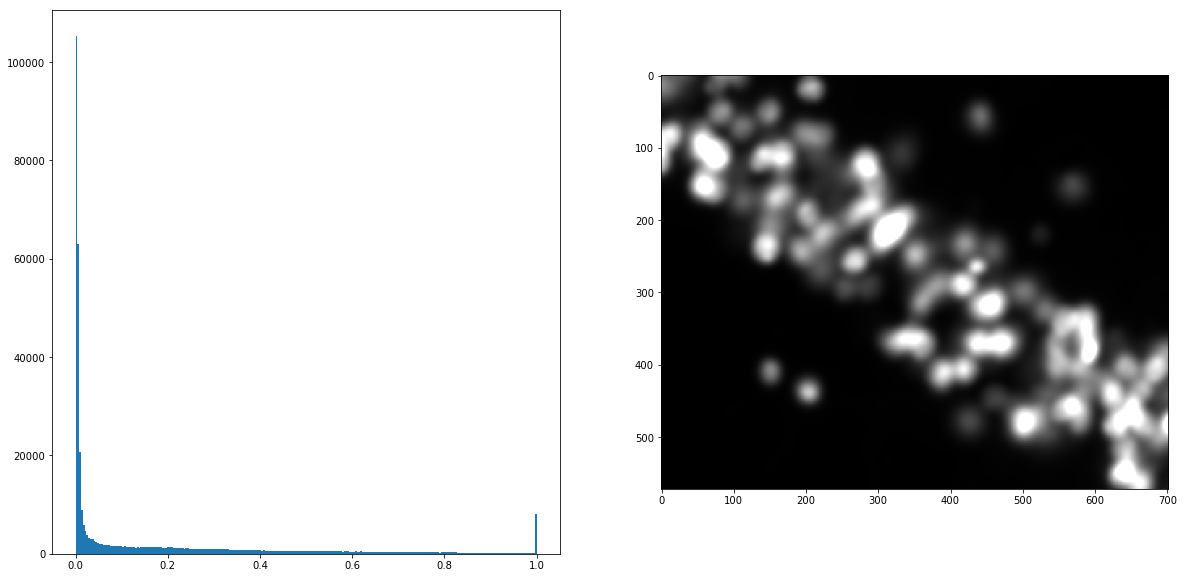

In [97]:
p2, p98 = np.percentile(test_blur_single, (2, 98))
img_rescale = exposure.rescale_intensity(test_blur_single, in_range=(p2, p98))

img_hist(img_rescale)

## Histogram equalization

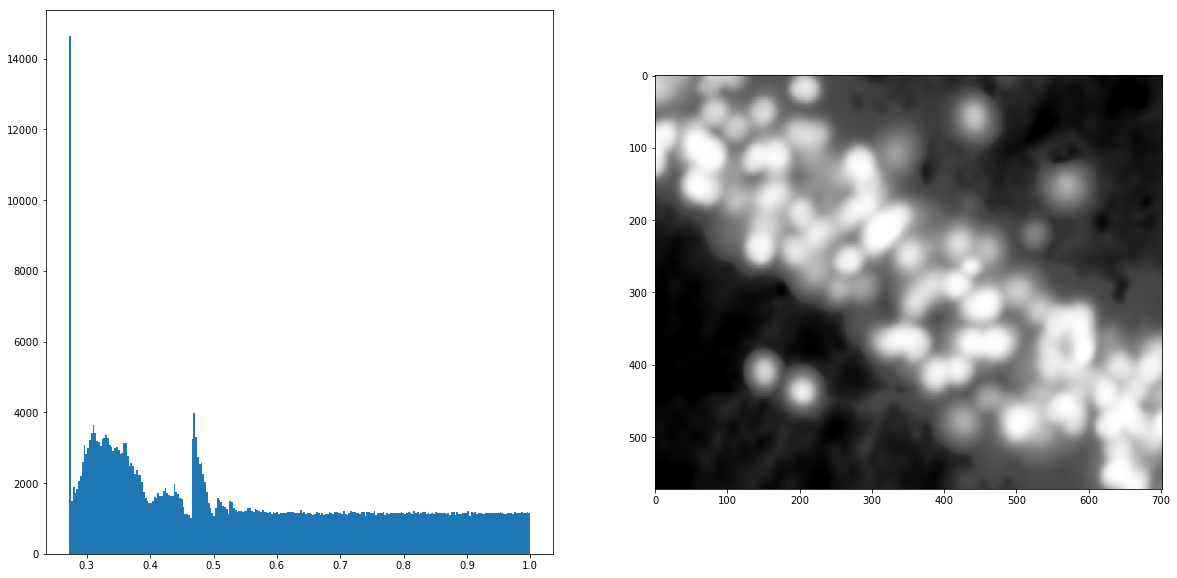

In [25]:
img_eq = exposure.equalize_hist(test_blur_single)

img_hist_single(img_eq)

## Adaptive equalization

/Users/KPuhger/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


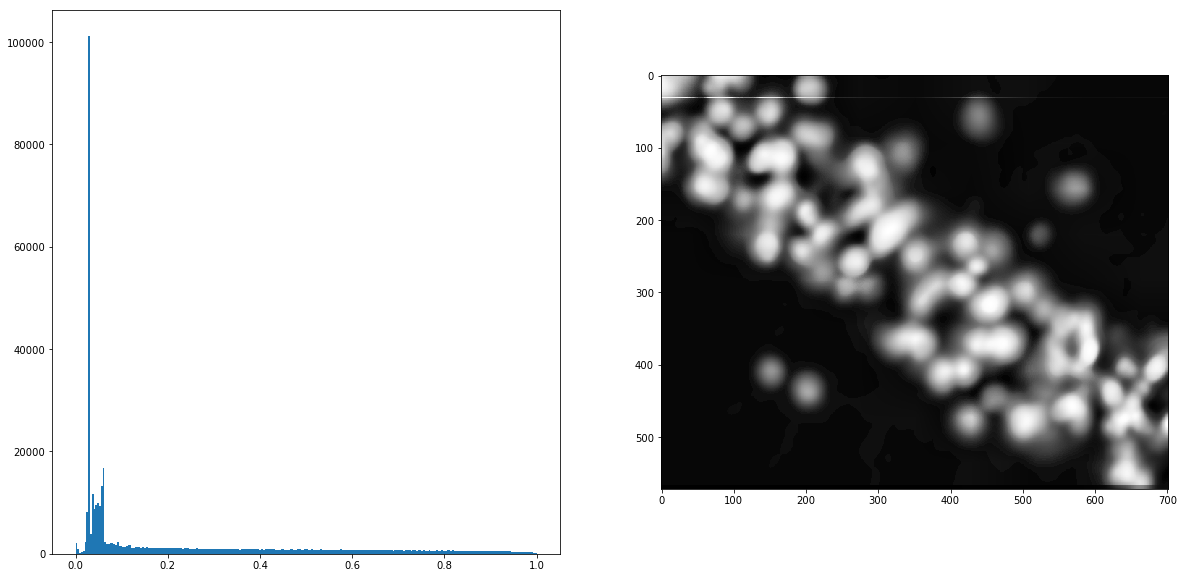

In [26]:
img_adapteq = exposure.equalize_adapthist(test_blur_single, clip_limit=0.03)

img_hist_single(img_adapteq)

In [32]:
# adapt_eq - adaptive histogram equalization

def adapt_eq(img):
    """
    input: a z-stack image
    output: an equalized z-stack image
    
    this function takes a z-stacked image and applies an adaptive histogram equalization algorithm 
    to each plane of the stack and returns the equalized z-stack
    """
       
    img_adeq = np.empty_like(img)
    for z in range(len(img)):
        img_adeq[z, :, :] = exposure.equalize_adapthist(img[z, :, :], clip_limit=0.03)
    return img_adeq

/Users/KPuhger/miniconda3/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


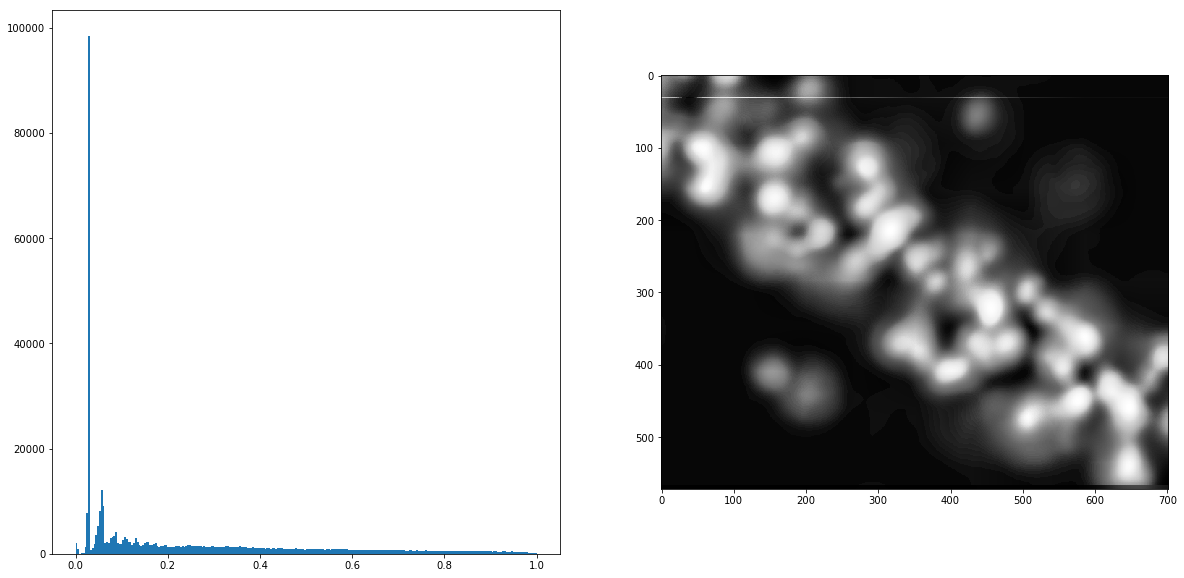

In [39]:
test_blur_adeq = adapt_eq(test_blur_stack)

img_hist_stack()

## Segmentation

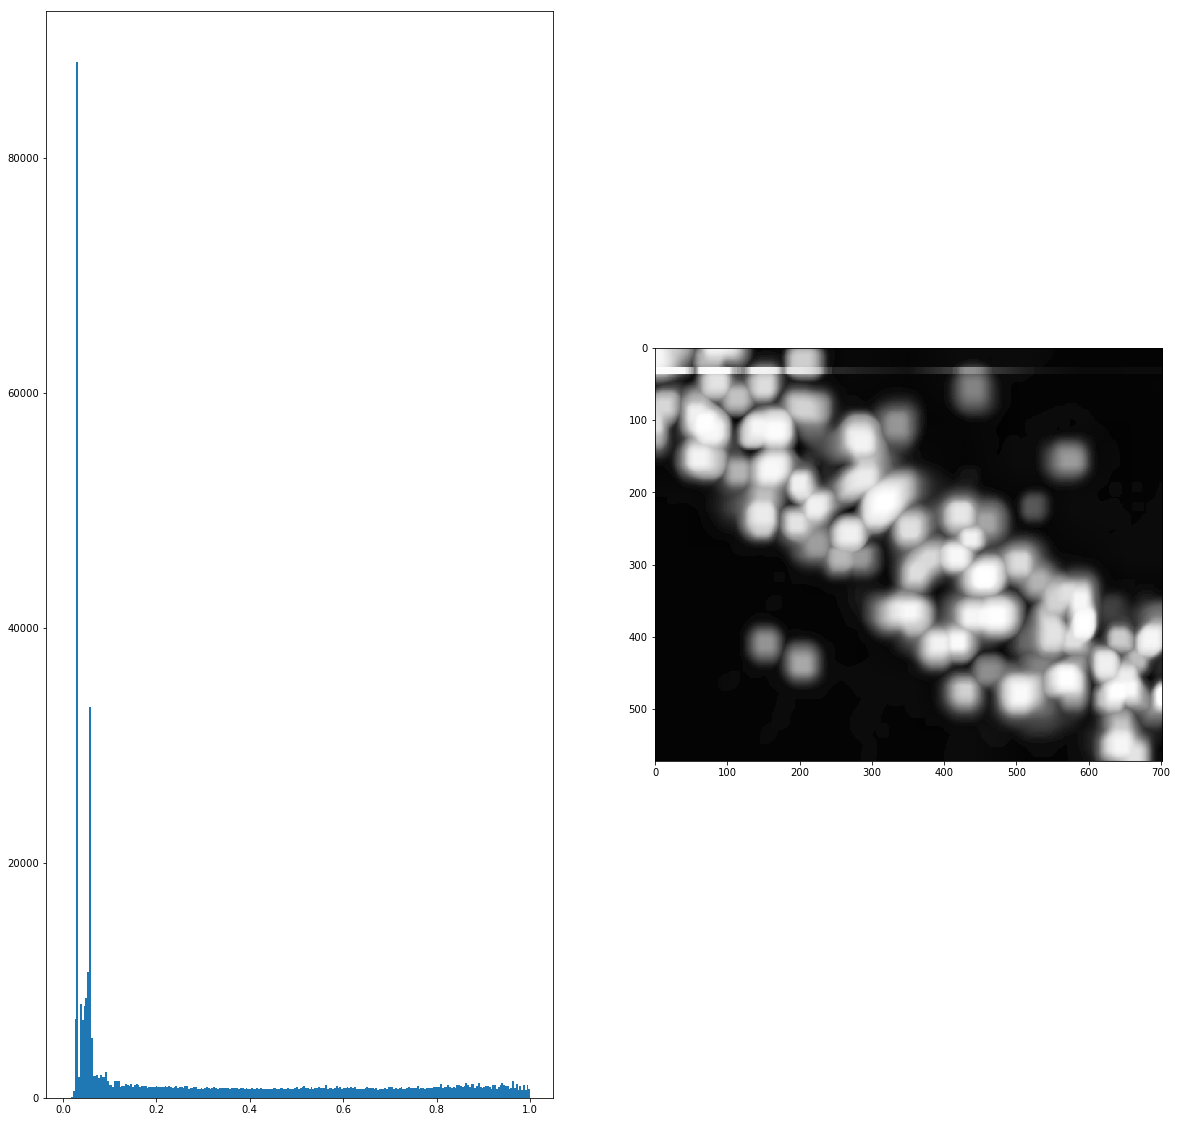

In [30]:
## finding local maxima

img_max = ndi.maximum_filter(img_adapteq, size=10)

img_hist(img_max)

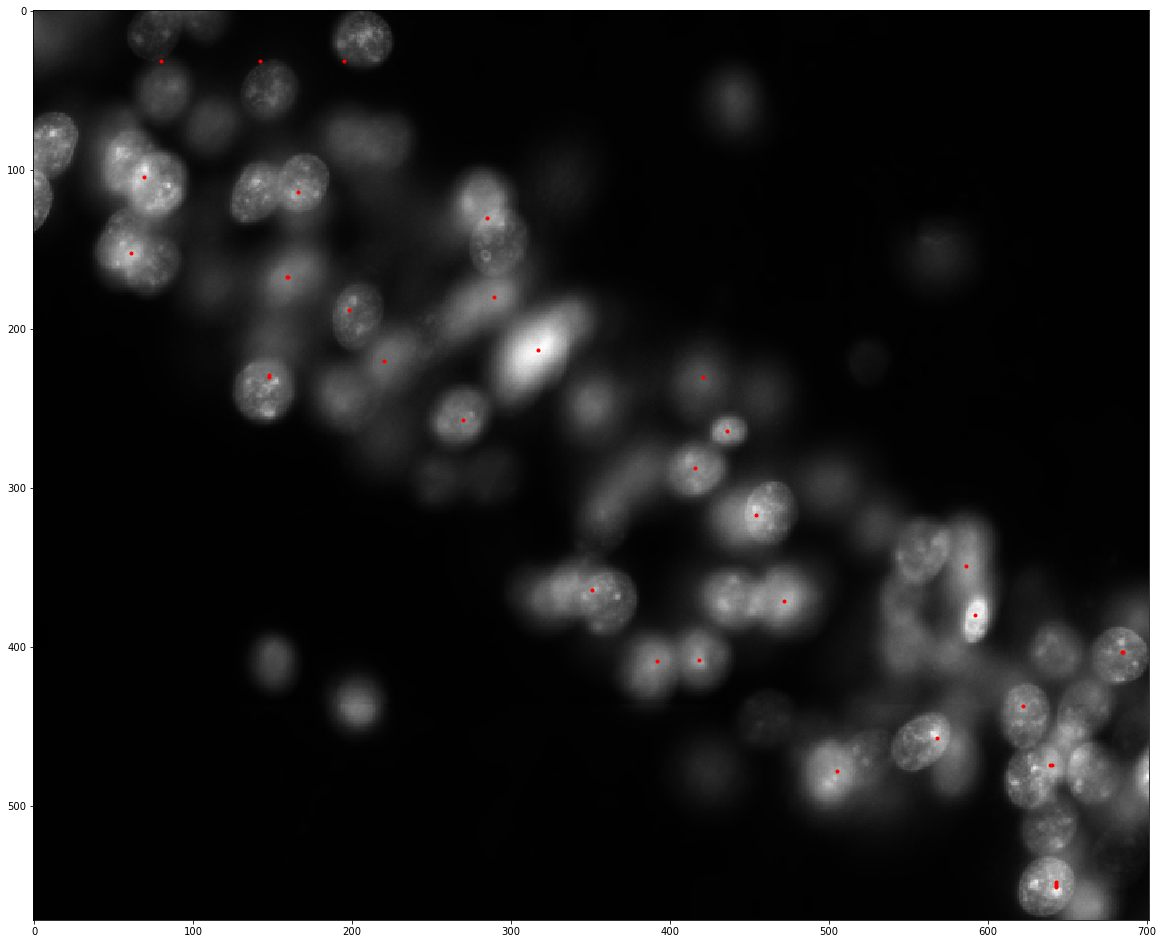

In [77]:
img_coords = peak_local_max(img_adapteq, min_distance=15, threshold_abs=0.9)

f, ax = plt.subplots(1,1, figsize=(20,20));
ax.imshow(img[9, :, :], cmap='gray');
ax.plot(img_coords[:, 1], img_coords[:, 0], 'r.');

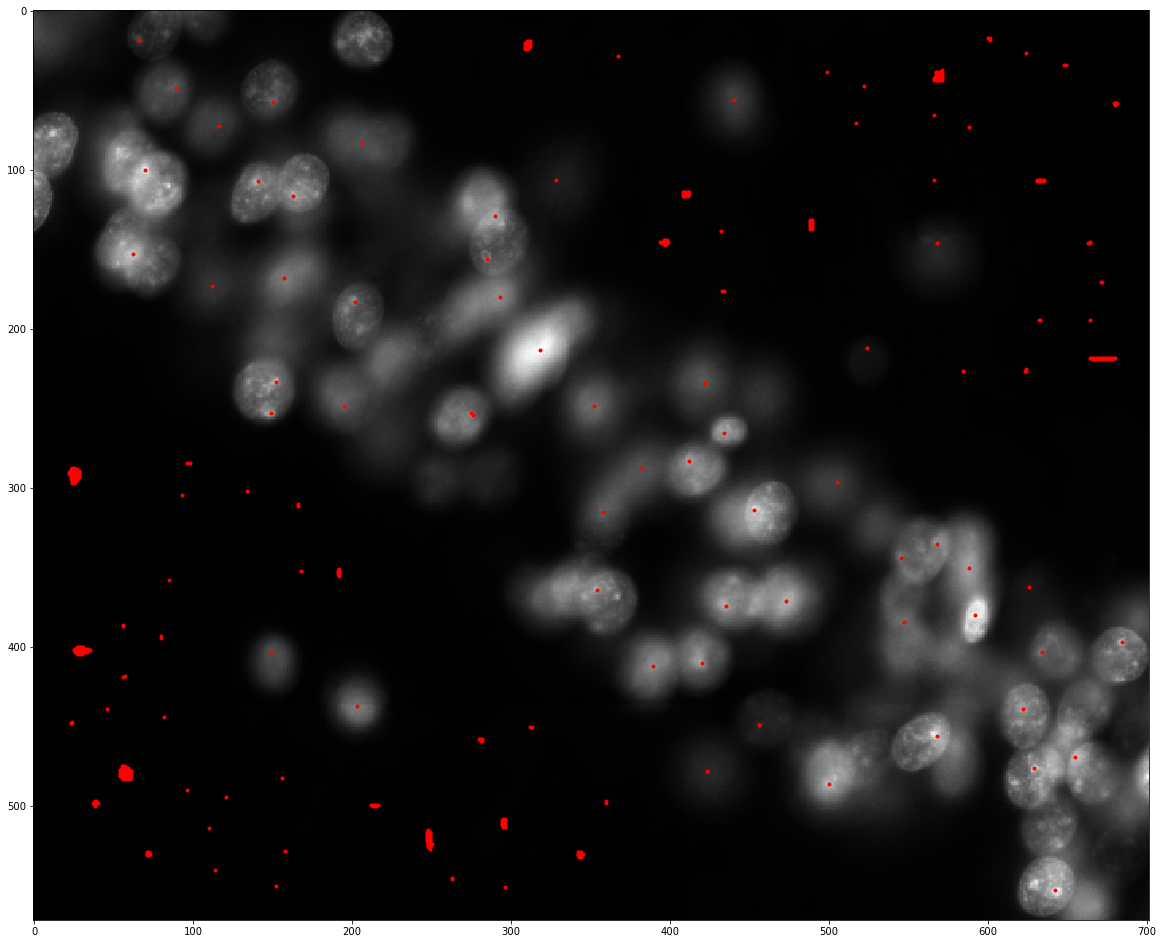

In [50]:
img_coords = peak_local_max(img[9, :, :], min_distance=15)

f, ax = plt.subplots(1,1, figsize=(20,20));
ax.imshow(img[9, :, :], cmap='gray');
ax.plot(img_coords[:, 1], img_coords[:, 0], 'r.');

In [53]:
img[9, :, :].max()

10659

# Work in progress

In [ ]:
class heq